__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

3294


,title,adr,latitude,longitude,priceM,ts
2488,Участок 4 сот. (ИЖС),"ул. Остен-Сакена, 29",44.56,33.54,4.25,2022-09-13 13:56:54.600
1781,Участок 10 сот. (ИЖС),"с. Широкое, ул. Булгакова",44.48,33.78,4.80,2022-09-12 13:51:16.745
947,Участок 5 сот. (ИЖС),"с. Ушаково, Полевая ул., 1",44.55,33.54,4.80,2022-09-08 16:04:40.227


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3294 entries, 0 to 3293
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   avito_id            3294 non-null   int64         
 1   title               3294 non-null   object        
 2   price               3294 non-null   int64         
 3   obj_name            3294 non-null   object        
 4   adr                 3294 non-null   object        
 5   description         3294 non-null   object        
 6   avito_page          3294 non-null   int64         
 7   ts                  3294 non-null   datetime64[ns]
 8   area                3294 non-null   float64       
 9   is_IJS              3294 non-null   bool          
 10  priceM              3294 non-null   float64       
 11  priceMU             3294 non-null   float64       
 12  area_size_category  3294 non-null   category      
 13  latitude            3294 non-null   float64     

In [7]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
1687,Участок 8 сот. (ИЖС),с. Угловое,44.82,33.61,2.10,2022-09-12 13:51:16.745
2648,"Участок 12,6 сот. (ИЖС)","Гагаринский муниципальный округ, микрорайон Омега-2А",44.59,33.44,29.00,2022-09-13 13:56:54.600
551,"Участок 4,4 сот. (ИЖС)","ОК ЖСТИЗ Оригинал, Ромашковый тупик, 17",44.58,33.58,2.40,2022-09-08 16:04:40.227


In [8]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

3294
3294


In [9]:
# # берём самые свежие объявления
# print(len(df))
# df = df[ (df['ts']==df['ts'].max()) ].reset_index(drop=True)
# print(len(df))

# cols = ['title','adr','latitude','longitude','priceM']
# df[cols]

### ограничиваем тип объекта 

In [10]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('is_IJS')
# df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

3294
3294


In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
3119,Участок 5 сот. (ИЖС),"ул. Бориса Шейнина, 97",44.58,33.56,2.70
885,Участок 9 сот. (ИЖС),"с. Угловое, ул. Гунько",44.83,33.59,3.50
613,Участок 5 сот. (ИЖС),Монастырское ш.,44.53,33.51,4.20


In [12]:
del df

In [13]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика изменение цены

In [14]:
ts = '2022-08-01' # ограничиваем дату

In [15]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean    std  min  10%   25%   50%   75%  \
area_size_category dt                                                           
<1                 2022-09-08   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-12   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-13   2.00  8.07   9.79 1.15 2.53  4.61  8.07 11.54   
1-2                2022-09-08   3.00  1.80   0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-12   3.00  1.80   0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-13   3.00  1.80   0.10 1.70 1.72  1.75  1.80  1.85   
2-4                2022-09-08 143.00  3.46   1.87 1.15 1.59  2.05  2.85  4.38   
                   2022-09-12 144.00  3.61   2.34 1.15 1.61  2.17  2.88  4.50   
                   2022-09-13 149.00  3.57   2.29 1.15 1.60  2.10  2.99  4.50   
4-8                2022-09-08 518.00  4.52   3.41 1.10 1.90  2.50  3.50  5.20   
                   2022-09-12 550.00  4.55   4.02 1.10 1.90  2.50  3.50  5.20   
                   2022-09-13 553.00  4.48   3.99 1.10 1.86  2.50  3.40  5.10   
8-20               2022-09-08 348.00  6.40   6.57 1.10 2.00  3.00  4.60  7.41   
                   2022-09-12 343.00  6.28   6.19 1.10 2.00  3.00  4.60  7.00   
                   2022-09-13 344.00  6.37   6.24 1.10 2.00  3.00  4.60  7.03   
20+                2022-09-08  36.00 80.86 201.21 1.10 6.00 14.00 26.00 51.00   
                   2022-09-12  36.00 55.37 146.21 1.10 3.70 11.50 21.00 41.00   
                   2022-09-13  36.00 57.11 146.05 1.10 5.25 13.12 21.00 51.00   

                                90%    max  
area_size_category dt                       
<1                 2022-09-08 13.61  15.00  
                   2022-09-12 13.61  15.00  
                   2022-09-13 13.61  15.00  
1-2                2022-09-08  1.88   1.90  
                   2022-09-12  1.88   1.90  
                   2022-09-13  1.88   1.90  
2-4                2022-09-08  6.00  11.70  
                   2022-09-12  6.14  20.00  
                   2022-09-13  6.00  20.00  
4-8                2022-09-08  8.13  29.00  
                   2022-09-12  8.00  60.00  
                   2022-09-13  8.00  60.00  
8-20               2022-09-08 12.00  60.00  
                   2022-09-12 11.82  48.00  
                   2022-09-13 12.00  48.00  
20+                2022-09-08 98.50 890.00  
                   2022-09-12 73.00 890.00  
                   2022-09-13 76.00 890.00

<AxesSubplot:title={'center':'цена на 2-4 сот'}, xlabel='dt'>

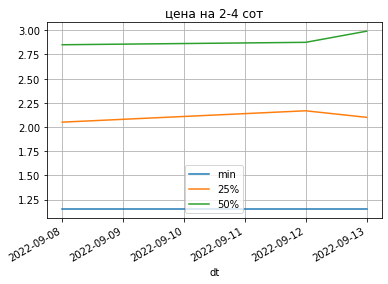

In [16]:
stat.loc['2-4',['min','25%','50%']].plot(grid=True, title='цена на 2-4 сот')

<AxesSubplot:title={'center':'цена на 8-20 сот'}, xlabel='dt'>

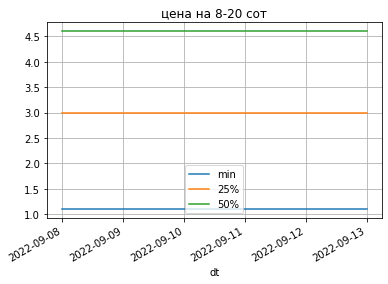

In [17]:
stat.loc['8-20',['min','25%','50%']].plot(grid=True, title='цена на 8-20 сот')

<AxesSubplot:title={'center':'цена на 4-8 сот'}, xlabel='dt'>

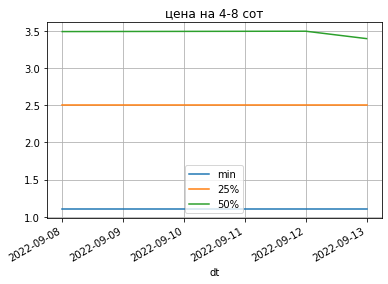

In [18]:
stat.loc['4-8',['min','25%','50%']].plot(grid=True, title='цена на 4-8 сот')

## ограничиваем по район поиска

In [19]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')
# frames_index

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames['area_id'] = range(len(frames))

frames

,area_name,geometry,area_id
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))",0
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))",1
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))",2
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))",3
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))",4
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))",5


<AxesSubplot:>

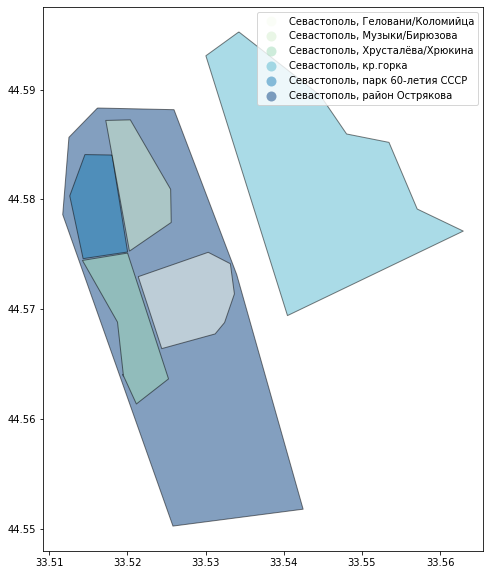

In [20]:
frames.plot('area_name', legend=True, cmap='GnBu', alpha=.5, edgecolor='k',figsize=(10,10),)  

In [21]:
# фильтруем по области
print(len(gdf))
gdf_in_frame = gdf.sjoin( frames.query('area_id in (5,)'), how='inner', predicate='within') 
print(len(gdf_in_frame))

3294
115


In [24]:
gdf_in_frame[['title','priceM','adr','area_size_category','geometry']].explore('area_size_category')#,legend=False)

In [25]:
# ctx.add_basemap(
#     gdf_in_frame[ (gdf_in_frame['dt']==gdf_in_frame['dt'].max()) ]
#       .plot(figsize=(21,21), color='r',marker='*'), 
#     crs=gdf.crs, 
#     zoom=16,
#     # source=ctx.providers.Stamen.TonerLite,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

### изменение цены

In [27]:
stat = (
    gdf_in_frame.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count   mean  std    min    10%    25%    50%  \
area_size_category dt                                                          
2-4                2022-09-08   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-12   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-13   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
4-8                2022-09-08  22.00   3.75 2.17   1.60   2.00   2.23   2.75   
                   2022-09-12  25.00   3.48 1.89   1.45   1.80   2.20   2.80   
                   2022-09-13  24.00   3.27 1.61   1.45   1.80   2.20   2.75   
8-20               2022-09-08  10.00   5.81 4.85   1.65   2.42   3.12   4.10   
                   2022-09-12   9.00   5.96 4.47   1.65   2.81   3.20   4.25   
                   2022-09-13  10.00   6.18 4.27   1.65   2.96   3.39   4.53   
20+                2022-09-08   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-12   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-13   1.00 120.00  NaN 120.00 120.00 120.00 120.00   

                                 75%    90%    max  
area_size_category dt                               
2-4                2022-09-08   2.95   3.40   3.70  
                   2022-09-12   2.95   3.40   3.70  
                   2022-09-13   2.95   3.40   3.70  
4-8                2022-09-08   4.78   7.86   8.50  
                   2022-09-12   4.50   5.88   8.50  
                   2022-09-13   3.97   4.80   8.00  
8-20               2022-09-08   5.55  12.41  17.00  
                   2022-09-12   5.80  12.52  15.00  
                   2022-09-13   7.60  12.21  15.00  
20+                2022-09-08 120.00 120.00 120.00  
                   2022-09-12 120.00 120.00 120.00  
                   2022-09-13 120.00 120.00 120.00

<AxesSubplot:title={'center':'цена на 2-4 сот'}, xlabel='dt'>

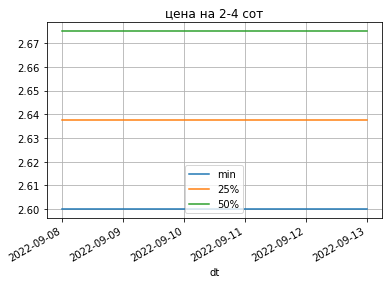

In [28]:
stat.loc['2-4',['min','25%','50%']].plot(grid=True, title='цена на 2-4 сот')

<AxesSubplot:title={'center':'цена на 4-8 сот'}, xlabel='dt'>

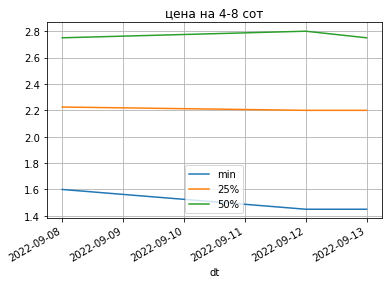

In [29]:
stat.loc['4-8',['min','25%','50%']].plot(grid=True, title='цена на 4-8 сот')

<AxesSubplot:title={'center':'цена на 8-20 сот'}, xlabel='dt'>

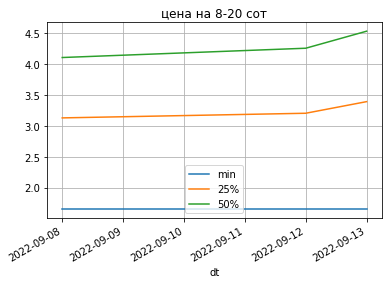

In [30]:
stat.loc['8-20',['min','25%','50%']].plot(grid=True, title='цена на 8-20 сот')

## гексагональная сетка

In [31]:
import h3
    
def cover_grid_hexagonal(gmtr,cell_size=9,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame(
        { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
        crs=crs, 
    )

grid = cover_grid_hexagonal( frames.query('area_id in (5,)').geometry.values[0] )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
0,892d2894067ffff,"POLYGON ((33.53063 44.59268, 33.53030 44.59089, 33.53239 44.58973, 33.53480 44.59035, 33.53512 44.59214, 33.53304 44.59330, 33.53063 44.59268))"
12,892d2894347ffff,"POLYGON ((33.55213 44.58464, 33.55180 44.58285, 33.55389 44.58169, 33.55630 44.58231, 33.55662 44.58410, 33.55454 44.58527, 33.55213 44.58464))"


In [ ]:
# ctx.add_basemap( 
#     grid.plot(alpha=.5,color='yellow',edgecolors='blue',figsize=(31,31),), 
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=grid.crs, 
#     zoom=16,
# )

### медиана актуальной цены

In [32]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM') #'area_name', legend=True)

In [33]:
import folium
start_pos = (44.578330, 33.516509)
# Create a map
my_map = folium.Map(location=start_pos, zoom_start=14,)

# Add the data
folium.Choropleth(
    name='choropleth',
    geo_data=grid,
    data=grid_values,
    columns=['hex_id','priceM',],
    key_on='feature.properties.hex_id',
    fill_color='YlOrRd',
    fill_opacity=.7,
    line_opacity=.2,
    legend_name='priceM median'
).add_to(my_map)
my_map

### количество предложений

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {  return false; }

<IPython.core.display.Javascript object>

In [38]:
# количество предложений
from folium import Map
from folium.plugins import HeatMap

start_pos = (44.578330, 33.516509)

Map(
    location=start_pos,
    zoom_start=12,
    # width=500,
    #height=2000,
).add_child( 
    HeatMap( 
        gdf[ gdf['dt']>ts ]
        .sjoin(frames.query('area_id in (5,)'),how='inner',predicate='within')
        [['latitude','longitude',]],
        #radius=10.,
        #min_opacity=3. 
    )
)


In [ ]:
# df = pd.read_pickle(data_file)
# df['priceMU'] = df['priceM']/df['area']

# area_bins = [ 0., 1., 2., 4., 8., 20., 1e6, ]
# labels =    [ '<1', '1-2','2-4', '4-8', '8-20', '20+' ]
# df['area_size_category'] = pd.cut( df['area'], bins = area_bins, labels=labels)

# df= df.drop(columns=['area_cut'])

# df.to_pickle(data_file)
# df[['title','adr','area','area_size_category','price','priceM','priceMU']]